# Reproduce scipy's filtering function

This example reproduces scipy's filtering by walking through the scipy's source code. 
Please refer to scipy.signal documentation for more details:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html

Some of the source files that include the function in this demo is from:
- signaltools.py
- _arraytools.py

You can find them under the directory where your scipy module is installed on your local computer. 

In [1]:
import numpy as np
import scipy

# these functions are from '_arraytools.py'

def axis_slice(a, start=None, stop=None, step=None, axis=-1):
    """
    Take a slice along axis 'axis' from 'a'.
    """
    a_slice = [slice(None)] * a.ndim
    a_slice[axis] = slice(start, stop, step)
    b = a[tuple(a_slice)]
    return b


def odd_ext(x, n, axis=-1):
    """
    Odd extension at the boundaries of an array

    Generate a new ndarray by making an odd extension of `x` along an axis.

    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.
    """
   
    if n < 1:
        return x
    if n > x.shape[axis] - 1:
        raise ValueError(("The extension length n (%d) is too big. " +
                         "It must not exceed x.shape[axis]-1, which is %d.")
                         % (n, x.shape[axis] - 1))
    left_end = axis_slice(x, start=0, stop=1, axis=axis)
    left_ext = axis_slice(x, start=n, stop=0, step=-1, axis=axis)
    right_end = axis_slice(x, start=-1, axis=axis)
    right_ext = axis_slice(x, start=-2, stop=-(n + 2), step=-1, axis=axis)
    ext = np.concatenate((2 * left_end - left_ext,
                          x,
                          2 * right_end - right_ext),
                         axis=axis)
    return ext


def even_ext(x, n, axis=-1):
    """
    Even extension at the boundaries of an array

    Generate a new ndarray by making an even extension of `x` along an axis.

    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.

    """
    if n < 1:
        return x
    if n > x.shape[axis] - 1:
        raise ValueError(("The extension length n (%d) is too big. " +
                         "It must not exceed x.shape[axis]-1, which is %d.")
                         % (n, x.shape[axis] - 1))
    left_ext = axis_slice(x, start=n, stop=0, step=-1, axis=axis)
    right_ext = axis_slice(x, start=-2, stop=-(n + 2), step=-1, axis=axis)
    ext = np.concatenate((left_ext,
                          x,
                          right_ext),
                         axis=axis)
    return ext


def const_ext(x, n, axis=-1):
    """
    Constant extension at the boundaries of an array

    Generate a new ndarray that is a constant extension of `x` along an axis.

    The extension repeats the values at the first and last element of
    the axis.

    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.

    Examples
    --------
    >>> from scipy.signal._arraytools import const_ext
    >>> a = np.array([[1, 2, 3, 4, 5], [0, 1, 4, 9, 16]])
    >>> const_ext(a, 2)
    array([[ 1,  1,  1,  2,  3,  4,  5,  5,  5],
           [ 0,  0,  0,  1,  4,  9, 16, 16, 16]])

    Constant extension continues with the same values as the endpoints of the
    array:

    >>> t = np.linspace(0, 1.5, 100)
    >>> a = 0.9 * np.sin(2 * np.pi * t**2)
    >>> b = const_ext(a, 40)
    >>> import matplotlib.pyplot as plt
    >>> plt.plot(arange(-40, 140), b, 'b', lw=1, label='constant extension')
    >>> plt.plot(arange(100), a, 'r', lw=2, label='original')
    >>> plt.legend(loc='best')
    >>> plt.show()
    """
    if n < 1:
        return x
    left_end = axis_slice(x, start=0, stop=1, axis=axis)
    ones_shape = [1] * x.ndim
    ones_shape[axis] = n
    ones = np.ones(ones_shape, dtype=x.dtype)
    left_ext = ones * left_end
    right_end = axis_slice(x, start=-1, axis=axis)
    right_ext = ones * right_end
    ext = np.concatenate((left_ext,
                          x,
                          right_ext),
                         axis=axis)
    return ext


#### given an array, get the required elements at given indecies

In [2]:
a = np.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# along axis=0, which is row in a
# get all the rows starting from row (index) 1 to the last row
axis_slice(a, start=1, axis=0)

array([[4, 5, 6],
       [7, 8, 9]])

#### Using odd_ext function to extend the signal at both ends.
Here extend n=2 points on both front and end.
Starting from the array [0,1,4,9,16], because we requires padding 2 points,
- at the begining, use index=2 (here 2 is determined by value of n), and moving along negative direction until index=0, so we will get, index=2, 1, but not include index=0. Thus, left_ext will be [4,1]
- at the end, use index=-2 (the second last value, here 2 is not depend on the value of n), and moving along negative direction until `-(n+2)`, which is index=-4, so will have index=-2, -3, but not include index=-4. Thus, the right_ext will be [9,4], because inputarray[-2]=9, inputarray[-3]=4.
- next, we will use `2*left_end - left_ext`, which is `2*0 - [4,1]`, thus has left padding as [-4,-1]. We will use `2*right_end - right_ext`, which is `2*16 - [9,4]`, thus has left padding as [23, 28]

In [3]:
x = np.array([0, 1, 4, 9, 16])
odd_ext(x, 2)

array([-4, -1,  0,  1,  4,  9, 16, 23, 28])

In [4]:
n=2
left_ext = axis_slice(x, start=n, stop=0, step=-1, axis=-1)
print('left_ext is: '+ str(left_ext))
print('left_padding is: '+ str(2*x[0] - left_ext))
right_ext = axis_slice(x, start=-2, stop=-(n + 2), step=-1, axis=-1)
print('right_ext is: '+ str(right_ext))
print('right_padding is: '+ str(2*x[-1] - right_ext))

left_ext is: [4 1]
left_padding is: [-4 -1]
right_ext is: [9 4]
right_padding is: [23 28]


#### Use even_ext function to extend functions at both ends.
Here, in this example, simple extend the signal 2 data points at each end, using the input signal.
For example array [1,2,3,4,5], 
- at the beginning, the extend values is 2, 3 (moving from the first element of the input signal to the negative direction), because after the first element 1 from the input signal, the next two elements are 2, 3
- at the very end, the extend values is 4, 3 (moving from the last element of the input signal to the positive direction), because after the last element 1 from the input signal, the next two elements are 4, 3

In [5]:
a = np.array([1, 2, 3, 4, 5])
even_ext(a, 2)

array([3, 2, 1, 2, 3, 4, 5, 4, 3])

In [6]:
# these functions are from 'signaltools.py'

def _validate_pad(padtype, padlen, x, axis, ntaps):
    """
    Helper to validate padding for filtfilt
    This function is just use the 'odd_ext' or 'even_ext' functions from above.
    """
    if padtype not in ['even', 'odd', 'constant', None]:
        raise ValueError(("Unknown value '%s' given to padtype.  padtype "
                          "must be 'even', 'odd', 'constant', or None.") %
                         padtype)

    if padtype is None:
        padlen = 0

    if padlen is None:
        # Original padding; preserved for backwards compatibility.
        edge = ntaps * 3
    else:
        edge = padlen

    # x's 'axis' dimension must be bigger than edge.
    if x.shape[axis] <= edge:
        raise ValueError("The length of the input vector x must be greater "
                         "than padlen, which is %d." % edge)

    if padtype is not None and edge > 0:
        # Make an extension of length `edge` at each
        # end of the input array.
        if padtype == 'even':
            ext = even_ext(x, edge, axis=axis)
        elif padtype == 'odd':
            ext = odd_ext(x, edge, axis=axis)
        else:
            ext = const_ext(x, edge, axis=axis)
    else:
        ext = x
    return edge, ext


### Generate a signal with noise, and conduct filtering

In [7]:
from numpy import sin, cos, pi, linspace
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter
from scipy import signal
import matplotlib.pyplot as plt

# Generate a noisy signal to be filtered.
t = linspace(-1, 1, 201)
x = (sin(2 * pi * 0.75 * t*(1-t) + 2.1) + 0.1*sin(2 * pi * 1.25 * t + 1) +
    0.18*cos(2 * pi * 3.85 * t))
xn = x + randn(len(t)) * 0.08

# Create an order 3 lowpass butterworth filter.
b, a = butter(3, 0.05)

#### First, we use the scipy.signal's built-in function signal.filtfilt to conduct the filtering

In [8]:
xn_filt = signal.filtfilt(b, a, xn, padtype='odd')

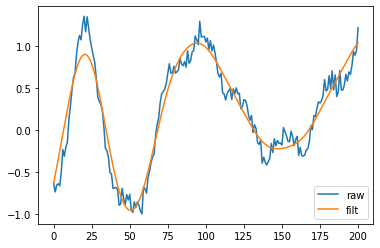

In [9]:
plt.figure()
plt.plot(xn)
plt.plot(xn_filt)
plt.legend(['raw','filt'])

#### Next, we will reproduce scipy.signal's filtfilt function

First, let's take a look at the the filter coefficients we generated above. Here, we designed a 3rd order butterworth filter using scipy's built-in pacage. 

In [10]:
print('b is :' + str(b))
print('a is :' + str(a))

b is :[0.00041655 0.00124964 0.00124964 0.00041655]
a is :[ 1.         -2.6861574   2.41965511 -0.73016535]


Then, we padd the signal using the function '_validate_pad()' listed above.
This function is basically just use odd_ext or even_ext function, depends on the 'padtype' parameter you defeine here.

As you can see, after pedding, we have added 12 data points on each side. The new signal after padding is with length 225, which is 24 points more than the original signal with a length of 201. 

Here, pay attention to the padlen=None. Because we have not assign a pad length, so in the '_validate_pad()' function, it will calculate the padlen based on the filer coefficients length. In this example, both coefficients a or b are with length of 4, so the 'ntaps' parameters is assigned with value 4. In the '_validate_pad()' function, 'padlen' is assigned with value 3*ntaps, which is the edge value of 12. Thus, our final padding will be using 'odd_ext' and extend the signal on both sides for 12 data points.  

In [11]:
padtype='odd'; padlen=None; method='pad'; axis=-1;
edge, ext = _validate_pad(padtype, padlen, xn, axis,ntaps=max(len(a), len(b)))

print("Before padding length (xn): " + str(len(xn)))
print("After padding length (ext): " + str(len(ext)))
print("Edge on each side of new signal (edge): " + str(edge) )

Before padding length (xn): 201
After padding length (ext): 225
Edge on each side of new signal (edge): 12


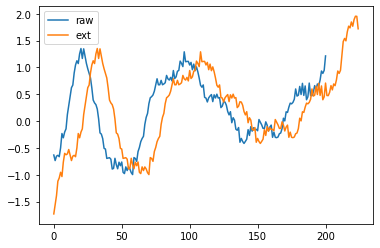

In [12]:
plt.figure()
plt.plot(xn)
plt.plot(ext)
plt.legend(['raw','ext'])

#### 1) Implement the filter with staty state response
#### Calculate the steady state of the filter's step response.
Refer to 'lfilter_zi(b, a)' in signaltools.py from scipy.signal for more details. 

In [13]:
b = np.atleast_1d(b)
if b.ndim != 1:
    raise ValueError("Numerator b must be 1-D.")
a = np.atleast_1d(a)
if a.ndim != 1:
    raise ValueError("Denominator a must be 1-D.")

while len(a) > 1 and a[0] == 0.0:
    a = a[1:]
if a.size < 1:
    raise ValueError("There must be at least one nonzero `a` coefficient.")

if a[0] != 1.0:
    # Normalize the coefficients so a[0] == 1.
    b = b / a[0]
    a = a / a[0]

n = max(len(a), len(b))

# Pad a or b with zeros so they are the same length.
if len(a) < n:
    a = np.r_[a, np.zeros(n - len(a))]
elif len(b) < n:
    b = np.r_[b, np.zeros(n - len(b))]

IminusA = np.eye(n - 1) - scipy.linalg.companion(a).T
B = b[1:] - a[1:] * b[0]
# Solve zi = A*zi + B
zi = np.linalg.solve(IminusA, B)
print(zi)

[ 0.99958345 -1.68782358  0.73058189]


#### 2) Implement the filter
Here, we implement two different conditions:
- when both a and b are given, and a and b are with the same length, we implement a IIR filter.
- when b is with higher length, a is with a single value, we implement a FIR filter. 

For IIR filter, we also can choose to implement the initial states in the filtered signal. When implementing intial states, the filtered signal is more align with the original shape of the signal.


#####  State representation of the filter and apply initial states to the filter

Part of the notes is from lfilter_zi( ) function in 'signaltools.py':

    A linear filter with order m has a state space representation (A, B, C, D),
    for which the output y of the filter can be expressed as::

        z(n+1) = A*z(n) + B*x(n)
        y(n)   = C*z(n) + D*x(n)

    where z(n) is a vector of length m, A has shape (m, m), B has shape
    (m, 1), C has shape (1, m) and D has shape (1, 1) (assuming x(n) is
    a scalar).  lfilter_zi solves::

        zi = A*zi + B*x(n)
        
        
Assuming `a(0)` is 1.0; if `a(0)` is not 1, `a` and `b` are first divided by `a(0)`.   

where, all the indexies here start from 0. 

x[n] is the data point of input time series x at index 'n'. 
When, first started, initial state zi will be scaled by the first data point in x,
that is zi = zi*x(0)

A is a companion matrix of coefficient a, with a size of (N-1, N-1)
  `| -a(1)  1  0  0 ... 0 |
   | -a(2)  0  1  0 ... 0 |
   |   .    0  0  1 ... 0 |
   |   .       .        . |
   |   .       .        . |
   | -a(N-1)  ...       1 |`
   
B is a vector with size of (N-1,)
`[b(1)-a(1)*b(0), b(2)-a(2)*b(0), b(3)-a(3)*b(0), ...  b(N-1)-a(N-1)*b(0)]`
       
C is a vector with size of (N-1,) `[1, 0, 0, ... 0]`

D = b(0)


Some of the posts discuss how to implement initial state to the filtered signal
https://stackoverflow.com/questions/27220671/matlab-filtfilt-function-implementation-in-java/52742099#52742099
https://dsp.stackexchange.com/questions/37619/zero-phase-filter-determining-initial-conditions-for-forward-backward-filtering

In [14]:
# based on the linear filter definition, define my FIR and IIR filters

def myIIRfilter(a, b, x, zi=None):
    '''
    Implement my own linear IIR filter
    
    Matlab's webpage present a very good explanation:
    https://www.mathworks.com/help/signal/ug/filter-implementation-and-analysis.html
    
    Below is the differential equation format.
    a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                          - a[1]*y[n-1] - ... - a[N]*y[n-N]
     
    b, numerator of a IIR filter coefficients
    a, denomenator of a IIR filter coefficients
    
    a,b must be the same order, and a[0] =1. 
    
    x, input signal, 1-D time searies.
    '''
    
    # if the first element in a is not 1, then normalize all the values in a and b
    # so that the first element in a is 1. 
    if a[0] != 1.0: b = b / a[0]; a = a / a[0];
    y = np.zeros_like(x) # initialize an empty array
    order = len(a)-1
    
    # WITHOUT INITIAL STATES IN THE FILTERED SIGNAL
    if zi is None:
        for n in range(len(x)):

            if   n==0: y[n] = b[0]*x[n]
            else:
                kernel_size = min(order, n)+1  # what is the kernel size, when n is smaller than order, there is no enough data points to fill the kernel size.
                # depends on where the kernel is moved along the time axis
                # find the part of the signal that the kernel need to be applied on
                if n<= order :
                    x_b = x[n:None:-1]   # from x[n] to x[0] including x[0]
                    y_b = y[n-1:None:-1] 

                elif n>order-1:
                    x_b = x[n:n-kernel_size:-1]    # start from x[n] to x[n-last], total number of 'kernel_size' elements
                    y_b = y[n-1:n-kernel_size:-1]  # start from y[n-1] to y[n-last], total number of 'kernel_size-1' elements

                # apply the dot multiplication on the kernel and the part of the signal
                y[n] = np.dot(b[0:kernel_size], x_b) - np.dot(a[1:kernel_size], y_b)

                
    # WITH INITIAL STATES IN THE FILTERED SIGNAL
    elif zi is not None:       
        # assume a is with size N  
        A = scipy.linalg.companion(a).T  # A is with size (N-1, N-1),create a companion matrix,  
        B = b[1:] - a[1:]*b[0]           # B is with size (N-1,)
        C = np.zeros((order,))        # C is with size (N-1,)
        C[0] = 1  # C is [1, 0,0, ...,0,0]
        D = b[0]  

        # Scale the initial state vector zi by the first input value
        z = zi * x[0]
    
        # Apply filter
        for n in range(len(x)):
            # Determine n-th output value (note this simplifies to y[n] = z[0] + b[0]*x[n])
            y[n] = np.dot(C, z) + D * x[n]
            # Determine next state (i.e. z[n+1])
            z = np.dot(A, z) + B * x[n] 
    
    return y



def myFIRfilter(a, b, x):
    '''
    Implement my own linear FIR filter
    
    Matlab's webpage present a very good explanation:
    https://www.mathworks.com/help/signal/ug/filter-implementation-and-analysis.html
    
    Below is the differential equation format.
    a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                          
    b, numerator of a FIR filter coefficients
    a, denomenator of a FIR filter coefficients, a only has one element
    
    x, input signal, 1-D time searies.
    '''
    b /= a[0]  # if a[0] if not 1, then normalize b with a

    out_full = np.convolve(b, x) # apply filtering kernel to the input signal after extended 
    total_length = len(x)  # the total length of the input signal after extended 
    out_len  = total_length - len(b) + 1 
    y      = out_full[0:out_len]  # return the output with the kernel length removed

    return y   

 Here, we apply the IIR filter as an example, since both coefficients a and b are with length of 4.
 First, we apply it with initial state response. 

Text(0.5, 1.0, 'Myfilter, with initial state response')

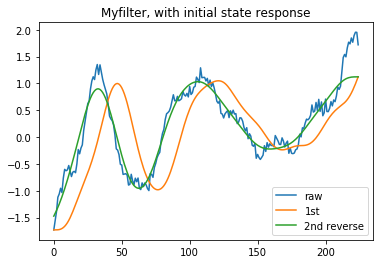

In [15]:
myz  = myIIRfilter(a, b, ext, zi=zi)
myz0 = myz[::-1]
myz1 = myIIRfilter(a, b, myz0, zi=zi)
myz2 = myz1[::-1]

if edge > 0: myowny = myz2[edge:-edge]

plt.figure()
#plt.subplot(3,1,1)
plt.plot(ext)
#plt.subplot(3,1,2)
plt.plot(myz)
#plt.subplot(3,1,3)
plt.plot(myz2)

plt.legend(['raw','1st','2nd reverse'])
plt.title('Myfilter, with initial state response')


 Then, we apply it without initial state response. 

Text(0.5, 1.0, 'Myfilter, without initial state response')

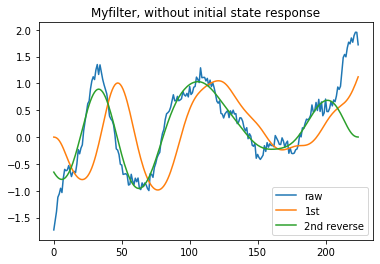

In [16]:
myz  = myIIRfilter(a, b, ext, zi=None)
myz0 = myz[::-1]
myz1 = myIIRfilter(a, b, myz0, zi=None)
myz2 = myz1[::-1]


plt.figure()
#plt.subplot(3,1,1)
plt.plot(ext)
#plt.subplot(3,1,2)
plt.plot(myz)
#plt.subplot(3,1,3)
plt.plot(myz2)

plt.legend(['raw','1st','2nd reverse'])
plt.title('Myfilter, without initial state response')


#### Compare the results from scipy.signal packge to the implementation above with initial state
Results are very very similar

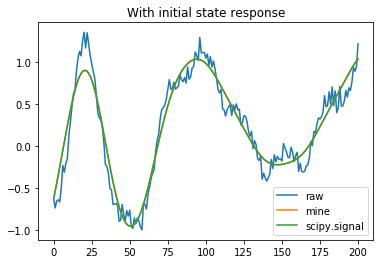

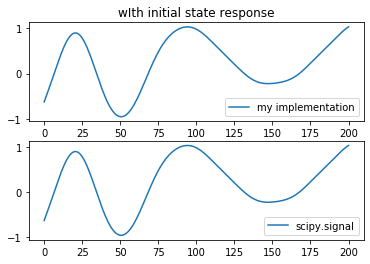

In [17]:
plt.figure()
plt.plot(xn)
plt.plot(myowny)
plt.plot(xn_filt)
plt.legend(['raw','mine','scipy.signal'])
plt.title('With initial state response')

plt.figure()
plt.subplot(2,1,1)
plt.plot(myowny)
plt.title('wIth initial state response')
plt.legend(['my implementation'])
plt.subplot(2,1,2)
plt.plot(xn_filt)
plt.legend(['scipy.signal'])


Print out the differences betweem the filtered signal using these two methods. 

In [18]:
print(myowny-xn_filt)

[-4.10782519e-15 -5.77315973e-15 -7.32747196e-15 -8.88178420e-15
 -1.02140518e-14 -1.12687637e-14 -1.21430643e-14 -1.27536870e-14
 -1.31006317e-14 -1.32116540e-14 -1.30451205e-14 -1.27120536e-14
 -1.23234756e-14 -1.16573418e-14 -1.08801856e-14 -1.02140518e-14
 -9.76996262e-15 -9.76996262e-15 -9.54791801e-15 -8.99280650e-15
 -8.65973959e-15 -8.43769499e-15 -8.43769499e-15 -8.77076189e-15
 -9.54791801e-15 -1.01030295e-14 -1.11022302e-14 -1.23234756e-14
 -1.35447209e-14 -1.45439216e-14 -1.53765889e-14 -1.61537450e-14
 -1.68198788e-14 -1.72917236e-14 -1.74860126e-14 -1.73819292e-14
 -1.69864123e-14 -1.62647673e-14 -1.51545443e-14 -1.34336986e-14
 -1.11022302e-14 -8.43769499e-15 -5.55111512e-15 -2.55351296e-15
  5.55111512e-16  2.99760217e-15  5.21804822e-15  6.88338275e-15
  7.54951657e-15  7.99360578e-15  7.88258347e-15  7.32747196e-15
  6.43929354e-15  5.77315973e-15  5.21804822e-15  4.88498131e-15
  4.32986980e-15  3.44169138e-15  2.66453526e-15  1.99840144e-15
  1.33226763e-15  5.55111